# Learner, Callbacks, Metrics and friends

Implementing the Learner and associated classes, callbacks, context managers and metrics etc

Start of build for convenience and experimentation tools, including lost of potential overcomplication from j.howard

## Context managers

In [30]:
class rnd_ctx:
    def __init__(self, msg): 
        self.msg = msg
    def __enter__(self):
        print('in', self.msg)
    def __exit__(self, exc_type, exc_value, traceback):
        if exc_type is not None: print(f'swallowing exception on exit: {exc_type} with value "{exc_value}"')
        print('exiting', self.msg)
        return True


In [31]:
with rnd_ctx('this my manager'):
    print('code in context')
    raise RuntimeError('aint having this ish')

print('not in contextmanager')

in this my manager
code in context
swallowing exception on exit: <class 'RuntimeError'> with value "aint having this ish"
exiting this my manager
not in contextmanager


In [32]:
from contextlib import contextmanager

In [73]:
@contextmanager
def another_ctx(msg):
    print('setting up context')
    vals = list(range(5))
    try:
        yield vals
    finally:
        print('exiting context')

In [74]:
with another_ctx('this another context') as vals:
    for v in vals: print(v)
    # print(vals)

setting up context
0
1
2
3
4
exiting context


### Decorator

In [75]:
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [76]:
def testing(b): b[0] = None

In [77]:
testing([0, 1, 2, 3])

In [78]:
@inplace
def testing(b): b[0] = None

In [79]:
testing([0, 1, 2, 3])

[None, 1, 2, 3]

## TODO move above code down to below main content

In [1]:
#|export
import math,torch,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy

from torch import optim
import torch.nn.functional as F

from miniai.conv import *

from fastprogress import progress_bar,master_bar

In [2]:
import matplotlib as mpl
import torchvision.transforms.functional as TF
from contextlib import contextmanager
from torch import nn,tensor
from datasets import load_dataset,load_dataset_builder
from miniai.datasets import *
from miniai.conv import *
import logging
from fastcore.test import test_close

In [3]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [4]:
logging.disable(logging.WARNING)

## Learner

In [5]:
x, y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)

In [6]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [7]:
bs = 1024
tds = dsd.with_transform(transformi)

In [8]:
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb.shape

(torch.Size([1024, 784]), torch.Size([1024]))

## Basic Callbacks Learner

In [9]:
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [10]:
class Callback(): order = 0

In [11]:
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)

In [12]:
class CompletionCB(Callback):
    def before_fit(self, learn): self.count = 0
    def after_batch(self, learn): self.count += 1
    def after_fit(self, learn): print(f'Completed {self.count} batches')

In [13]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

Completed 1 batches


In [14]:
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD):
        self.model, self.dls, self.loss_func, self.lr, self.cbs, self.opt_func = model, dls, loss_func, lr, cbs, opt_func

    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.iter, self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass
            self.callback('after_epoch')
        except CancelEpochException: pass

    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: pass

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

In [15]:
m, nh = 28 * 28, 50
def get_model(): return nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [16]:
model = get_model()
learn = Learner(model, dls, F.cross_entropy, 0.2, cbs=[CompletionCB()])
learn.fit(1)

Completed 64 batches


In [17]:
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn): raise CancelFitException()

In [18]:
learn = Learner(model, dls, F.cross_entropy, 0.2, cbs=[CompletionCB(), SingleBatchCB()])
# learn = Learner(model, dls, F.cross_entropy, 0.2, cbs=[CompletionCB()])
learn.fit(1)

## Metrics

In [19]:
class Metric:
    def __init__(self): self.reset()
    def reset(self): self.vals, self.ns = [], []
    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals) * ns).sum() / ns.sum()
    def calc(self, inps, targs): return inps

In [20]:
class Accuracy(Metric):
    def calc(self, inps, targs): return (inps == targs).float().mean()

In [21]:
acc = Accuracy()
acc.add(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
acc.add(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]))
acc.value

tensor(0.45)

In [22]:
loss = Metric()
loss.add(0.69, n=32)
loss.add(0.9, n=2)
loss.value, (0.69 * 32 + 0.9 * 2) / (32 + 2)

(tensor(0.70), 0.7023529411764705)

## Metrics callbacks using pytorch torcheval lib

In [23]:
from torcheval.metrics import MulticlassAccuracy, Mean

In [24]:
metric = MulticlassAccuracy()
metric.update(tensor([0, 1, 2, 3]), tensor([0, 2, 1, 3]))
metric.compute()

tensor(0.50)

In [25]:
metric.reset()
metric.compute()

tensor(nan)

In [26]:
def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype == torch.float16 else res

In [27]:
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn):
        for o in self.all_metrics.values(): o.reset()
    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k, v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)
    def after_batch(self, learn):
        x, y, *_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [32]:
class DeviceCB(Callback):
    def __init__(self, device=def_device): self.device = device
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)

In [33]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(1)

{'accuracy': '0.608', 'loss': '1.174', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.686', 'loss': '0.882', 'epoch': 0, 'train': 'eval'}


In [34]:
def_device

'cpu'

## Learner

note this is the updated version that fixes the issues with contextlib.contextmanager that doesn't allow raising before the yield statement

In [63]:
class with_cbs:
    def __init__(self, nm): self.nm = nm
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.nm}')
        return _f

In [74]:
class Learner:
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        # self.model, self.dls, self.loss_func, self.lr, self.cbs, self.opt_func = model, dls, loss_func, lr, cbs, opt_func
        fc.store_attr()

    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter, self.batch in enumerate(self.dl): self._one_batch()

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()

    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # from L18: add_cb and rm_cb
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)
    
    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

    @property
    def training(self): return self.model.training
        

### TrainCB and ProgressCB

Using an additional option for n_inp that allows us to use tuples as the input to the model of any lengh and extract what's needed.
Note that typically in pytorch/transformers they will expect a single input but for diffusion there's the input and there's `t`.
This also allows us to take the batch without assuming and splitting out the `(input, target)[0]` for `input`.

Personally I'd probably just subclass the Trainer, but this works too. Not sure what's the benefit exactly and needs the hack in Trainer to getattr for things that aren't implemented to go look in callbacks.

Bit dubious about the usefulness of ProgressCB. The plotting is definitely useful, but using the custom progress bar seems a bit pointless given tdqm is good enough

In [82]:
class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

In [90]:
class ProgressCB(Callback):
    order = MetricsCB.order + 1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []
    
    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: self.mbar.update_graph([[list(range(len(self.losses))), self.losses], [list(map(lambda x: (x+1)*len(learn.dls.train), range(learn.epoch))), self.val_losses]])
    
    def after_epoch(self, learn):
        if learn.training or not (self.plot and hasattr(learn, 'metrics')):
            return
        self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
        self.mbar.update_graph([[list(range(len(self.losses))), self.losses], [list(map(lambda x: (x+1)*len(learn.dls.train), range(learn.epoch+1))), self.val_losses]])
    # def after_epoch(self, learn): 
    #     if not learn.training:
    #         if self.plot and hasattr(learn, 'metrics'): 
    #             self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
    #             self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])

accuracy,loss,epoch,train
0.612,1.174,0,train
0.692,0.826,0,eval
0.734,0.724,1,train
0.751,0.692,1,eval


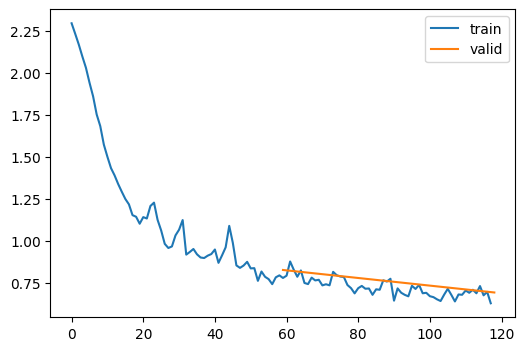

In [91]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(2)